# BRIEF DESCRIPTION OF DATASET
**This dataset consists of about Liar dataset.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/NLP_Project

Mounted at /content/drive
/content/drive/MyDrive/NLP_Project


# LOADING THE NECESSARY LIBRARIES

In [ ]:
import numpy as np
import gensim.downloader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

# IMPORTING THE DATASET

In [ ]:
train_data = pd.read_csv("liar_dataset/train.tsv", delimiter='\t')
valid_data = pd.read_csv("liar_dataset/valid.tsv", delimiter='\t')
test_data = pd.read_csv("liar_dataset/test.tsv", delimiter='\t')

# DATA VISUALIZATION AND PREPROCESSING

In [ ]:
train_data.head()

,2635.json,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0.1,0.2,0.3,a mailer
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


In [ ]:
test_data.head()

,11972.json,true,Building a wall on the U.S.-Mexico border will take literally years.,immigration,rick-perry,Governor,Texas,republican,30,30.1,42,23,18,Radio interview
0,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
1,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
2,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
3,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video
4,5962.json,true,Over the past five years the federal governmen...,"federal-budget,pensions,retirement",brendan-doherty,NaN,Rhode Island,republican,1,2,1,1,0,a campaign website


In [ ]:
#Taking text and label columns
train_data = train_data.iloc[:, [1, 2]]
test_data = test_data.iloc[:, [1, 2]]
valid_data = valid_data.iloc[:, [1, 2]]

In [ ]:
train_data.columns = ['Label', 'Text']
test_data.columns = ['Label', 'Text']
valid_data.columns = ['Label', 'Text']

In [ ]:
#keeping 'true', 'false', 'mostly-true', 'barely-true' labels
labels_to_keep = ['true', 'false', 'mostly-true', 'barely-true']

train_data = train_data[train_data['Label'].isin(labels_to_keep)]
test_data = test_data[test_data['Label'].isin(labels_to_keep)]
valid_data = valid_data[valid_data['Label'].isin(labels_to_keep)]

In [ ]:
#combining train and valid data
combined_dataset = pd.concat([train_data,valid_data], ignore_index=True)
print(combined_dataset.shape)
#converting mostly-true to true and barely-true to false label
combined_dataset['Label'] = combined_dataset['Label'].replace({'mostly-true': 'true', 'barely-true': 'false'})
combined_dataset.head()

(8205, 2)


,Label,Text
0,true,"Hillary Clinton agrees with John McCain ""by vo..."
1,false,Health care reform legislation is likely to ma...
2,true,The Chicago Bears have had more starting quart...
3,false,Jim Dunnam has not lived in the district he re...
4,true,Says GOP primary opponents Glenn Grothman and ...


In [ ]:
#converting false to 0 and true to 1
combined_dataset['Label'] = pd.get_dummies(combined_dataset.Label)['true']
test_data['Label'] = pd.get_dummies(test_data.Label)['true']
print(test_data.shape)

(909, 2)


In [ ]:
test_data.reset_index(drop=True, inplace=True)

test_data.head()

,Label,Text
0,0,Wisconsin is on pace to double the number of l...
1,0,Says John McCain has done nothing to help the ...
2,1,Over the past five years the federal governmen...
3,1,Says that Tennessee law requires that schools ...
4,0,"Says Vice President Joe Biden ""admits that the..."


In [ ]:
combined_dataset.head()

,Label,Text
0,1,"Hillary Clinton agrees with John McCain ""by vo..."
1,0,Health care reform legislation is likely to ma...
2,1,The Chicago Bears have had more starting quart...
3,0,Jim Dunnam has not lived in the district he re...
4,1,Says GOP primary opponents Glenn Grothman and ...


In [ ]:
def plot_label_distribution(df, dataset_name):
    # Count the occurrences of each unique label
    label_counts = df['Label'].value_counts()
    plt.figure(figsize = (5,6))
    # Plot the bar chart with numbers on top of the bars
    bars = plt.bar(label_counts.index, label_counts.values)

    # Add numbers on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1), ha='center', va='bottom')

    # Add labels and title

    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title(f'Distribution of Labels in the {dataset_name} Dataset')

    # Show the plot
    plt.show()

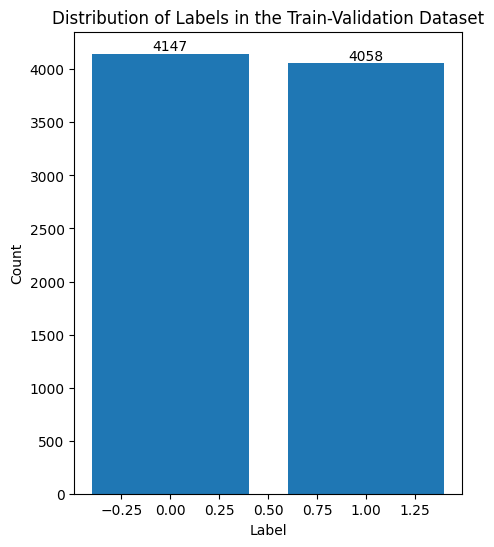

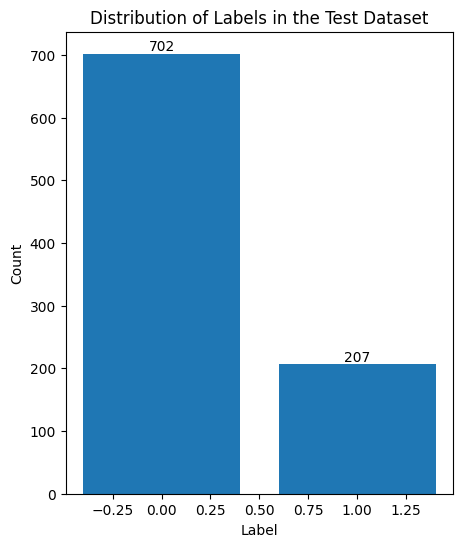

In [ ]:
# Plot the distribution for the train dataset
plot_label_distribution(combined_dataset, 'Train-Validation')

# Plot the distribution for the test dataset
plot_label_distribution(test_data, 'Test')

In [ ]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(combined_dataset, test_size=0.2, random_state=42, stratify=combined_dataset['Label']) # THE DATASET IS BALANCED



**SO, WE CAN SEE THAT THE DATASET IS BALANCED**

In [ ]:
# Check the label distribution in the training set
print("Training set label distribution:")
print(train_df['Label'].value_counts())

# Check the label distribution in the validation set
print("\nValidation set label distribution:")
print(valid_df['Label'].value_counts())

Training set label distribution:
0    3318
1    3246
Name: Label, dtype: int64

Validation set label distribution:
0    829
1    812
Name: Label, dtype: int64


In [ ]:
train_df.head()

,Label,Text
1027,1,Says the Central Ohio Human Trafficking Task F...
386,1,"On Lee Fishers watch, almost nine out of 10 jo..."
6674,0,Says Missouri Democratic Senate candidateJason...
8168,1,Says Rick Scotts per-pupil education spending ...
8186,0,"Barack Obama has ""pledged to reduce the size o..."


**WHAT ARE STOPWORDS?**

**Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We first download it to our python environment.**

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**DATA CLEANING**

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on text column
train_df['Text']=train_df['Text'].apply(denoise_text)
valid_df['Text']=valid_df['Text'].apply(denoise_text)
test_data['Text']=test_data['Text'].apply(denoise_text)

<ipython-input-19-bc1e209a24ac>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
# Check the label distribution in the training set
print("Training set label distribution:")
print(train_df['Label'].value_counts())

# Check the label distribution in the validation set
print("\nValidation set label distribution:")
print(valid_df['Label'].value_counts())

# Check the label distribution in the Test set
print("\nTest set label distribution:")
print(test_data['Label'].value_counts())

Training set label distribution:
0    3318
1    3246
Name: Label, dtype: int64

Validation set label distribution:
0    829
1    812
Name: Label, dtype: int64

Test set label distribution:
0    702
1    207
Name: Label, dtype: int64


**WORDCLOUD FOR REAL TEXT in training data**

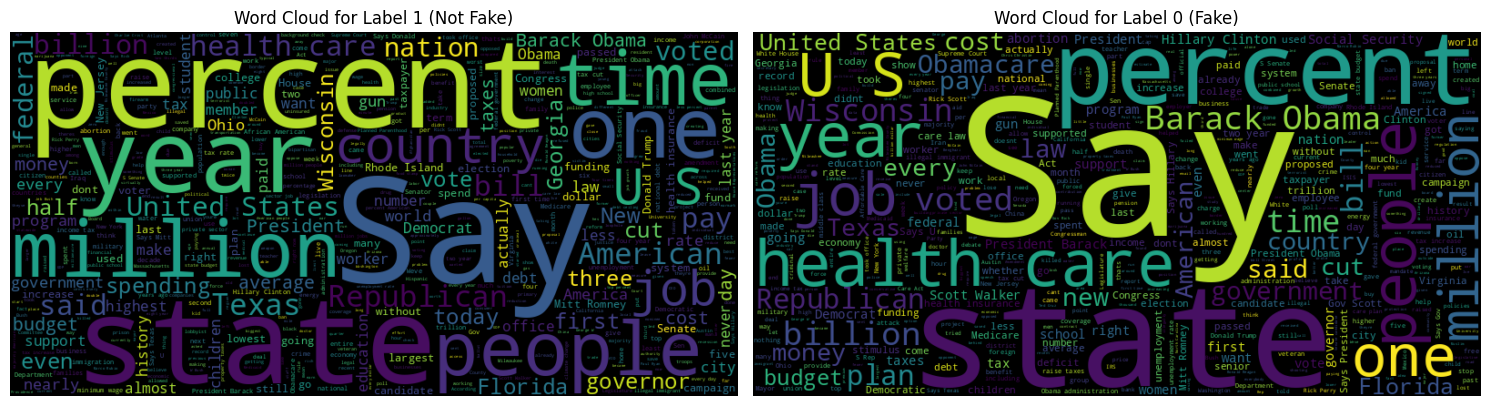

In [ ]:
# Set up a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# WordCloud for Label 1 (Not Fake)
wc_label_1 = WordCloud(max_words=2000, width=800, height=400, stopwords=STOPWORDS).generate(" ".join(train_df[train_df.Label == 1].Text))
axes[0].imshow(wc_label_1, interpolation='bilinear')
axes[0].set_title('Word Cloud for Label 1 (Not Fake)')
axes[0].axis('off')  # Turn off axis labels

# WordCloud for Label 0 (Fake)
wc_label_0 = WordCloud(max_words=2000, width=800, height=400, stopwords=STOPWORDS).generate(" ".join(train_df[train_df.Label == 0].Text))
axes[1].imshow(wc_label_0, interpolation='bilinear')
axes[1].set_title('Word Cloud for Label 0 (Fake)')
axes[1].axis('off')  # Turn off axis labels

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
def get_corpus(data):
    words = []
    for text in data['Text']:
        for word in text.split():
            words.append(word.strip())
    return words

# Assuming you have separate dataframes for train, test, and valid datasets
# Replace 'train_df', 'test_df', and 'valid_df' with the actual names of your dataframes

# Get corpus for training set
train_corpus = get_corpus(train_df)

# Get corpus for test set
test_corpus = get_corpus(test_data)

# Get corpus for validation set
valid_corpus = get_corpus(valid_df)

# Example of printing the first 10 words in each corpus
print("Train Corpus (first 10 words):", train_corpus[:10])
print("Test Corpus (first 10 words):", test_corpus[:10])
print("Valid Corpus (first 10 words):", valid_corpus[:10])

Train Corpus (first 10 words): ['Says', 'Central', 'Ohio', 'Human', 'Trafficking', 'Task', 'Force', 'first', 'task', 'force']
Test Corpus (first 10 words): ['Wisconsin', 'pace', 'double', 'number', 'layoffs', 'year.', 'Says', 'John', 'McCain', 'done']
Valid Corpus (first 10 words): ['Says', 'months', 'special', 'session', 'cost', 'state', '$27,300', 'day', 'legislators', 'daily']


In [ ]:
from collections import Counter

def get_most_common_words(data, num_words=10):
    words = []
    for text in data['Text']:
        for word in text.split():
            words.append(word.strip())

    counter = Counter(words)
    most_common = counter.most_common(num_words)
    most_common_dict = dict(most_common)

    return most_common_dict

# Assuming you have separate dataframes for train, test, and valid datasets
# Replace 'train_df', 'test_df', and 'valid_df' with the actual names of your dataframes

# Get most common words for training set
train_most_common = get_most_common_words(train_df)

# Get most common words for test set
test_most_common = get_most_common_words(test_data)

# Get most common words for validation set
valid_most_common = get_most_common_words(valid_df)

# Example of printing the most common words for each dataset
print("Most Common Words in Train Dataset:", train_most_common)
print("\nMost Common Words in Test Dataset:", test_most_common)
print("\nMost Common Words in Valid Dataset:", valid_most_common)


Most Common Words in Train Dataset: {'Says': 1395, 'percent': 614, 'state': 383, 'tax': 363, 'health': 356, 'Obama': 347, 'people': 338, 'would': 329, 'million': 281, 'U.S.': 267}

Most Common Words in Test Dataset: {'Says': 187, 'percent': 100, 'tax': 56, 'state': 52, 'Obama': 52, 'health': 50, 'people': 43, 'billion': 40, 'U.S.': 40, 'federal': 38}

Most Common Words in Valid Dataset: {'Says': 363, 'percent': 175, 'Obama': 98, 'tax': 95, 'state': 94, 'people': 80, 'million': 80, 'would': 78, 'health': 77, 'President': 66}


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

def get_top_text_ngrams(data, n, g, text_column='Text'):
    corpus = data[text_column]

    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    return words_freq[:n]

# Function to create the top n-grams bar plot
def plot_top_ngrams(ax, data, title, n, g, text_column='Text'):
    most_common_ngrams = get_top_text_ngrams(data, n, g, text_column)
    most_common_ngrams = dict(most_common_ngrams)
    sns.barplot(x=list(most_common_ngrams.values()), y=list(most_common_ngrams.keys()), ax=ax)
    ax.set_title(f'{title} - {g}-grams')

**Unigram Analysis**

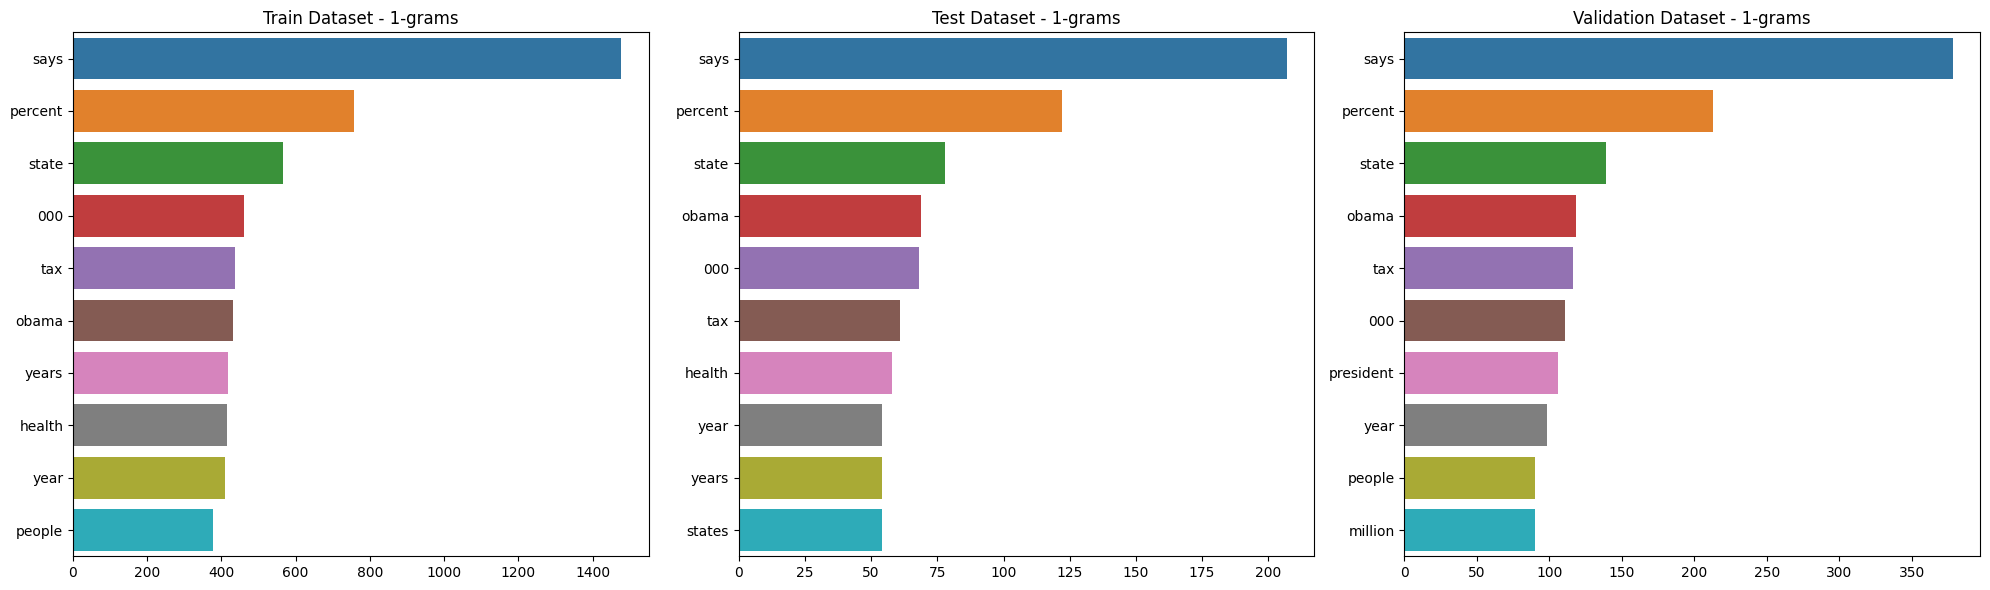

In [ ]:

# Set up a 1x3 grid for subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
# Plot for training set - 1-gram
plot_top_ngrams(axes[0], train_df, 'Train Dataset', 10, 1)

# Plot for test set - 1-gram
plot_top_ngrams(axes[1], test_data, 'Test Dataset', 10, 1)

# Plot for validation set - 1-gram
plot_top_ngrams(axes[2], valid_df, 'Validation Dataset', 10, 1)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

**Bigram Analysis**

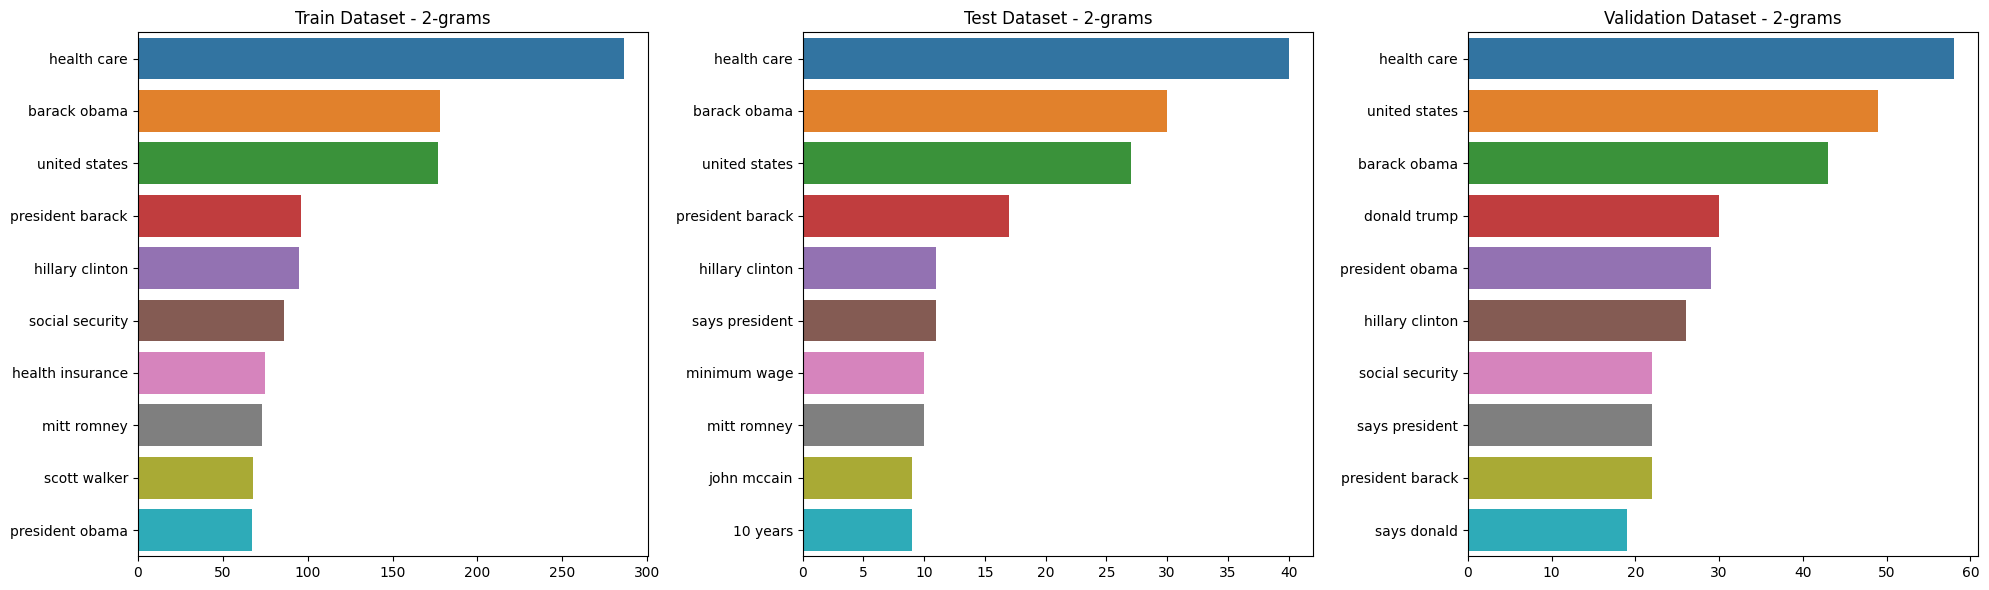

In [ ]:
# Set up a 1x3 grid for subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot for training set - 2-grams
plot_top_ngrams(axes[0], train_df, 'Train Dataset', 10, 2)

# Plot for test set - 2-grams
plot_top_ngrams(axes[1], test_data, 'Test Dataset', 10, 2)

# Plot for validation set - 2-grams
plot_top_ngrams(axes[2], valid_df, 'Validation Dataset', 10, 2)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

**Trigram Analysis**

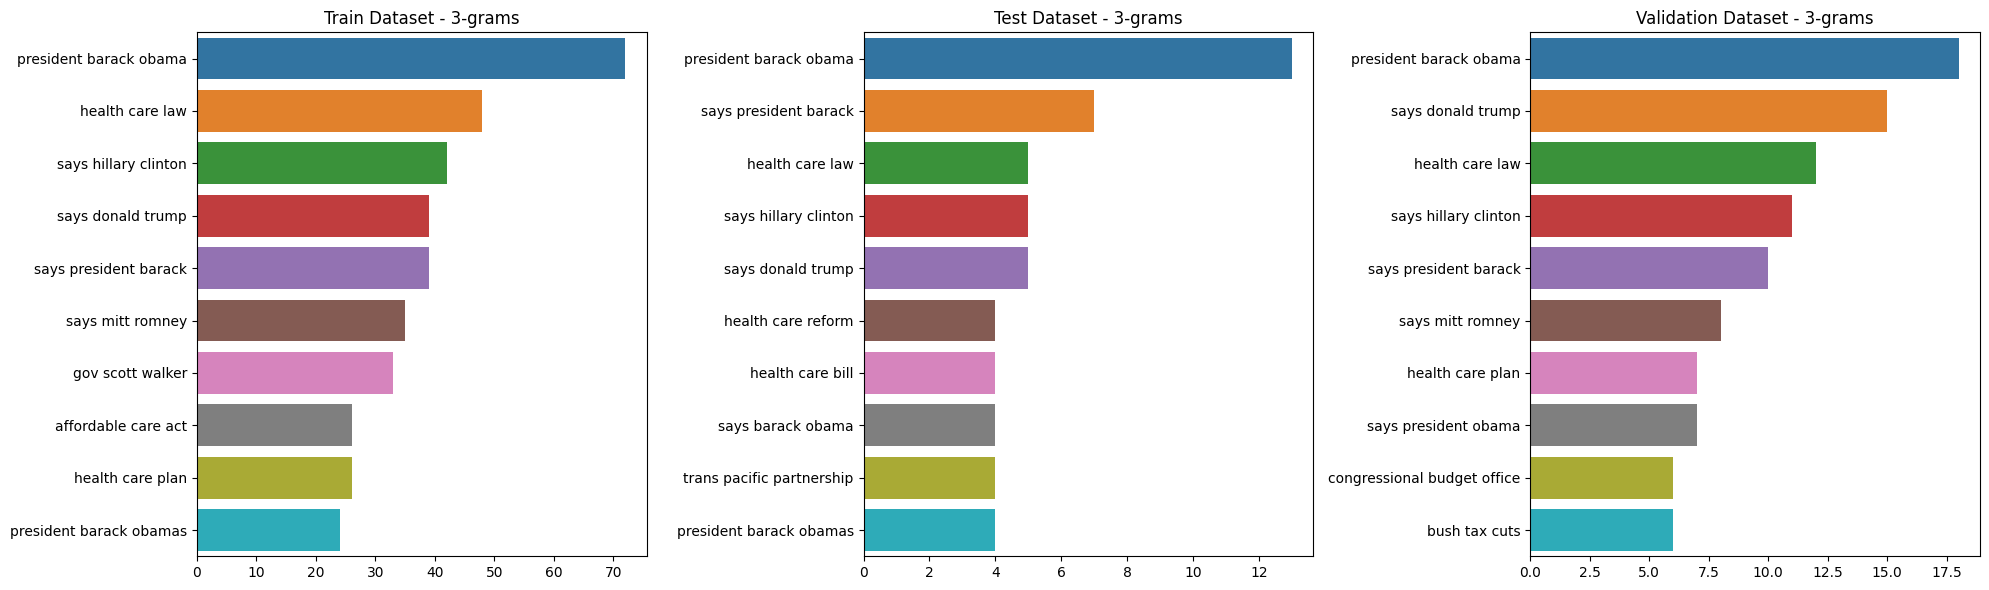

In [ ]:
# Set up a 1x3 grid for subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot for training set - 3-grams
plot_top_ngrams(axes[0], train_df, 'Train Dataset', 10, 3)

# Plot for test set - 3-grams
plot_top_ngrams(axes[1], test_data, 'Test Dataset', 10, 3)

# Plot for validation set - 3-grams
plot_top_ngrams(axes[2], valid_df, 'Validation Dataset', 10, 3)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
max_features = 10000
maxlen = 100

**Tokenizing Text -> Repsesenting each word by a number**

**Mapping of orginal word to number is preserved in word_index property of tokenizer**

**Tokenized applies basic processing like changing it to lower case, explicitely setting that as False**

**Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones**

In [ ]:
# Tokenization and Padding for training set
tokenizer_train = text.Tokenizer(num_words=max_features)
tokenizer_train.fit_on_texts(train_df['Text'])
tokenized_train = tokenizer_train.texts_to_sequences(train_df['Text'])
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

# Tokenization and Padding for test set
tokenizer_test = text.Tokenizer(num_words=max_features)
tokenizer_test.fit_on_texts(test_data['Text'])
tokenized_test = tokenizer_test.texts_to_sequences(test_data['Text'])
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

# Tokenization and Padding for validation set
tokenizer_valid = text.Tokenizer(num_words=max_features)
tokenizer_valid.fit_on_texts(valid_df['Text'])
tokenized_valid = tokenizer_valid.texts_to_sequences(valid_df['Text'])
x_valid = sequence.pad_sequences(tokenized_valid, maxlen=maxlen)

## Check the number of unique words in your train,validand test dataset

In [ ]:

# For training dataset
unique_words_train = set(word for sequence in tokenized_train for word in sequence)
number_of_unique_words_train = len(unique_words_train)
print(f"Number of unique words in the training dataset: {number_of_unique_words_train}")

# For test dataset
unique_words_test = set(word for sequence in tokenized_test for word in sequence)
number_of_unique_words_test = len(unique_words_test)
print(f"Number of unique words in the test dataset: {number_of_unique_words_test}")

# For validation dataset
unique_words_valid = set(word for sequence in tokenized_valid for word in sequence)
number_of_unique_words_valid = len(unique_words_valid)
print(f"Number of unique words in the validation dataset: {number_of_unique_words_valid}")

Number of unique words in the training dataset: 9961
Number of unique words in the test dataset: 3518
Number of unique words in the validation dataset: 4909


# Introduction to GloVe
**GloVe method is built on an important idea,
You can derive semantic relationships between words from the co-occurrence matrix.
Given a corpus having V words, the co-occurrence matrix X will be a V x V matrix, where the i th row and j th column of X, X_ij denotes how many times word i has co-occurred with word j. An example co-occurrence matrix might look as follows.**
![image.png](attachment:image.png)

**The co-occurrence matrix for the sentence “the cat sat on the mat” with a window size of 1. As you probably noticed it is a symmetric matrix.
How do we get a metric that measures semantic similarity between words from this? For that, you will need three words at a time. Let me concretely lay down this statement.**

**![image.png](attachment:image.png)
The behavior of P_ik/P_jk for various words
Consider the entity
P_ik/P_jk where P_ik = X_ik/X_i
Here P_ik denotes the probability of seeing word i and k together, which is computed by dividing the number of times i and k appeared together (X_ik) by the total number of times word i appeared in the corpus (X_i).
You can see that given two words, i.e. ice and steam, if the third word k (also called the “probe word”),
is very similar to ice but irrelevant to steam (e.g. k=solid), P_ik/P_jk will be very high (>1),
is very similar to steam but irrelevant to ice (e.g. k=gas), P_ik/P_jk will be very small (<1),
is related or unrelated to either words, then P_ik/P_jk will be close to 1
So, if we can find a way to incorporate P_ik/P_jk to computing word vectors we will be achieving the goal of using global statistics when learning word vectors.**

**Source Credits - https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010**

In [ ]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
import gensim.downloader
gensim.downloader.load('glove-twitter-100')


[==================================================] 100.0% 387.1/387.1MB downloaded


In [ ]:
from gensim.models import KeyedVectors
import gensim.downloader

EMBEDDING_FILE = "glove-twitter-100"

# Download and load the pre-trained word vectors
word_vectors = gensim.downloader.load(EMBEDDING_FILE)


In [ ]:
# def get_coefs(word, *arr):
#     return word, np.asarray(arr, dtype='float32')
# embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
max_features_train = 10000  # Replace with your actual value
maxlen_train = 100
# Create a dictionary with words as keys and vectors as values
embeddings_index = {word: word_vectors[word] for word in word_vectors.index_to_key}
all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

# Get the number of words for each dataset
nb_words_train = min(max_features, len(word_index_train))
nb_words_test = min(max_features, len(word_index_test))
nb_words_valid = min(max_features, len(word_index_valid))

# Set max_features based on the number of unique words in each dataset
max_features_train = min(max_features, len(word_index_train))
max_features_test = min(max_features, len(word_index_test))
max_features_valid = min(max_features, len(word_index_valid))

# Initialize the embedding matrix for each dataset
embedding_matrix_train = np.random.normal(emb_mean, emb_std, (max_features_train, embed_size))
embedding_matrix_test = np.random.normal(emb_mean, emb_std, (max_features_test, embed_size))
embedding_matrix_valid = np.random.normal(emb_mean, emb_std, (max_features_valid, embed_size))

# Create the embedding matrix for the training dataset
embedding_matrix_train = np.random.normal(emb_mean, emb_std, (max_features_train, embed_size))
for word, i in word_index_train.items():
    if i >= max_features_train:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_train[i] = embedding_vector

# Fill the embedding matrix with pre-trained word vectors for test set
for word, i in word_index_test.items():
    if i >= max_features_test:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_test[i] = embedding_vector

# Fill the embedding matrix with pre-trained word vectors for validation set
for word, i in word_index_valid.items():
    if i >= max_features_valid:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_valid[i] = embedding_vector


**Some Model Parameters**

In [ ]:
batch_size = 256
epochs = 10
embed_size = 100

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

# TRAINING THE MODEL

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Assuming you have defined max_features_train and maxlen_train based on your training dataset
max_features_train = 10000  # Replace with your actual value
maxlen_train = 100  # Replace with your actual value

# Create the embedding matrix for the training dataset
embedding_matrix_train = np.random.normal(emb_mean, emb_std, (max_features_train, embed_size))
for word, i in word_index_train.items():
    if i >= max_features_train:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_train[i] = embedding_vector

# Define the Sequential model
model = Sequential()

# Non-trainable embedding layer with pre-trained weights
model.add(Embedding(max_features_train, output_dim=embed_size, weights=[embedding_matrix_train], input_length=maxlen_train, trainable=False))

# LSTM layers
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))
model.add(LSTM(units=64, recurrent_dropout=0.1, dropout=0.1))

# Dense layers
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 100, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1168769 (4.46 MB)
Trainable params: 168769 (659.25 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________________________________________________________


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Assuming you have train_df, valid_df, and test_df DataFrames
max_features = 10000
maxlen = 100

# Tokenization and Padding for training set
tokenizer_train = Tokenizer(num_words=max_features)
tokenizer_train.fit_on_texts(train_df['Text'])
tokenized_train = tokenizer_train.texts_to_sequences(train_df['Text'])
x_train = pad_sequences(tokenized_train, maxlen=maxlen)

# Tokenization and Padding for test set
tokenizer_test = Tokenizer(num_words=max_features)
tokenizer_test.fit_on_texts(test_data['Text'])
tokenized_test = tokenizer_test.texts_to_sequences(test_data['Text'])
x_test = pad_sequences(tokenized_test, maxlen=maxlen)

# Tokenization and Padding for validation set
tokenizer_valid = Tokenizer(num_words=max_features)
tokenizer_valid.fit_on_texts(valid_df['Text'])
tokenized_valid = tokenizer_valid.texts_to_sequences(valid_df['Text'])
x_valid = pad_sequences(tokenized_valid, maxlen=maxlen)

# Convert labels to numpy arrays
y_train = train_df['Label'].values
y_test = test_data['Label'].values
y_valid = valid_df['Label'].values

# Create the embedding matrix using GloVe
embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
for word, i in tokenizer_train.word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define the Sequential model
model = Sequential()

# Non-trainable embedding layer with pre-trained weights
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))

# LSTM layers
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))
model.add(LSTM(units=64, recurrent_dropout=0.1, dropout=0.1))

# Dense layers
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and record the training history
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    validation_data=(x_valid, y_valid),
    epochs=epochs,
    callbacks=[learning_rate_reduction]
)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_accuracy}')


Epoch 1/10
26/26 [==============================] - 35s 1s/step - loss: 0.6894 - accuracy: 0.5433 - val_loss: 0.6970 - val_accuracy: 0.5070 - lr: 0.0010
Epoch 2/10
26/26 [==============================] - 27s 1s/step - loss: 0.6692 - accuracy: 0.5949 - val_loss: 0.7009 - val_accuracy: 0.5259 - lr: 0.0010
Epoch 3/10
26/26 [==============================] - 24s 940ms/step - loss: 0.6664 - accuracy: 0.5987 - val_loss: 0.7078 - val_accuracy: 0.5143 - lr: 0.0010
Epoch 4/10
26/26 [==============================] - 27s 1s/step - loss: 0.6576 - accuracy: 0.6133 - val_loss: 0.7059 - val_accuracy: 0.5277 - lr: 0.0010
Epoch 5/10
26/26 [==============================] - 24s 929ms/step - loss: 0.6587 - accuracy: 0.6150 - val_loss: 0.7112 - val_accuracy: 0.5241 - lr: 0.0010
Epoch 6/10
26/26 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.6223
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
26/26 [==============================] - 27s 1s/step - loss

# ANALYSIS AFTER TRAINING OF MODEL

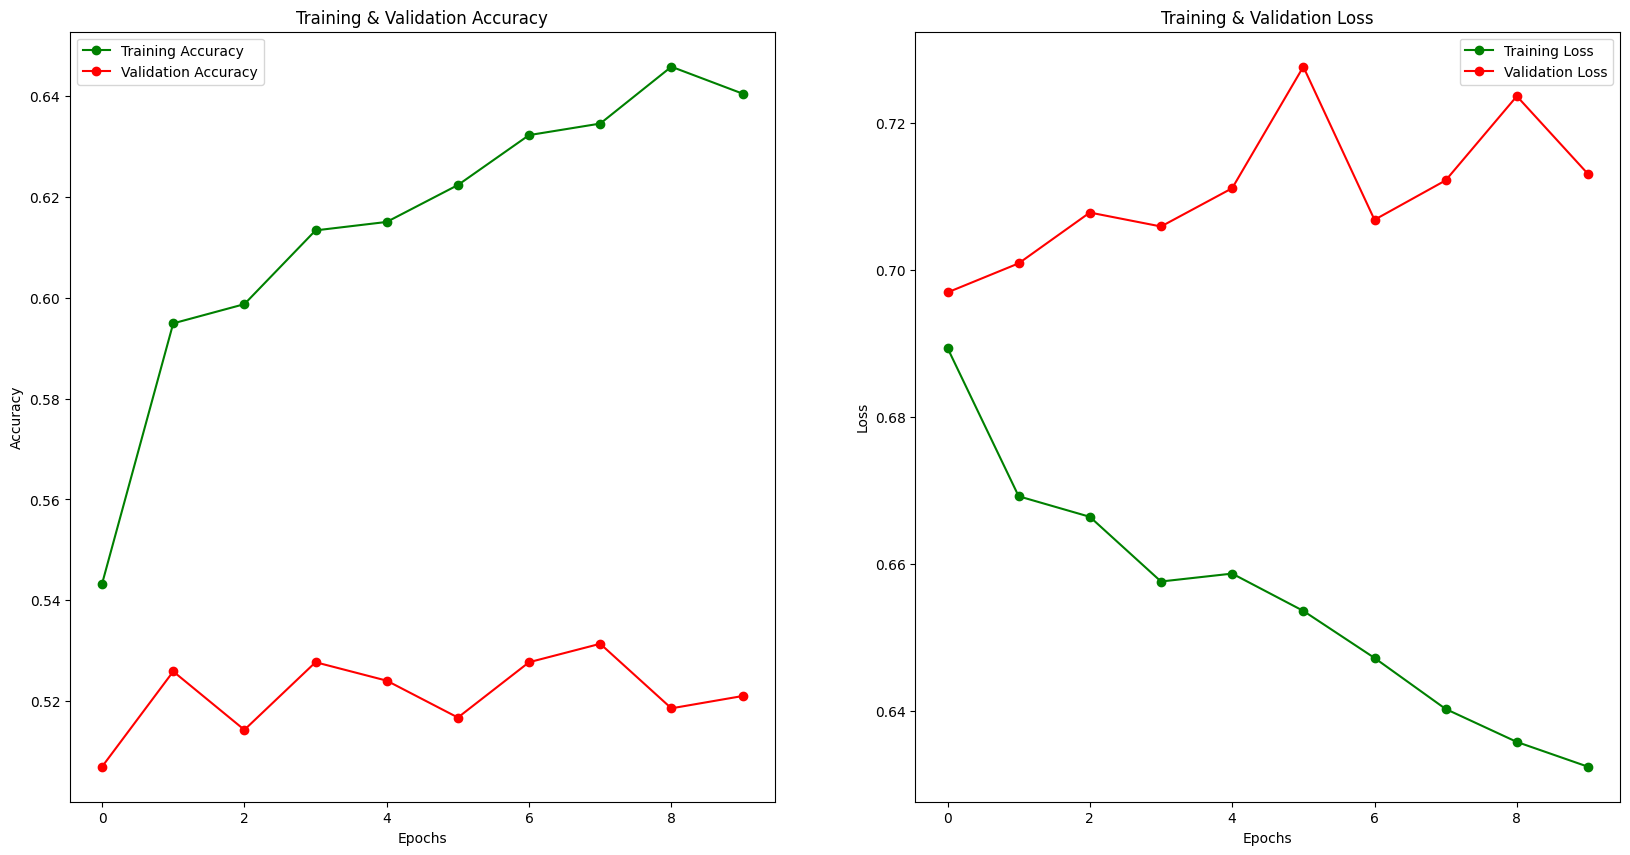

In [ ]:
# Assuming you have the following code after training your model
epochs = [i for i in range(10)]

# Assuming your history variable is defined (history = model.fit(...))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plotting
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

# Training & Testing Accuracy Plot
ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Training & Testing Loss Plot
ax[1].plot(epochs, train_loss, 'go-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()
